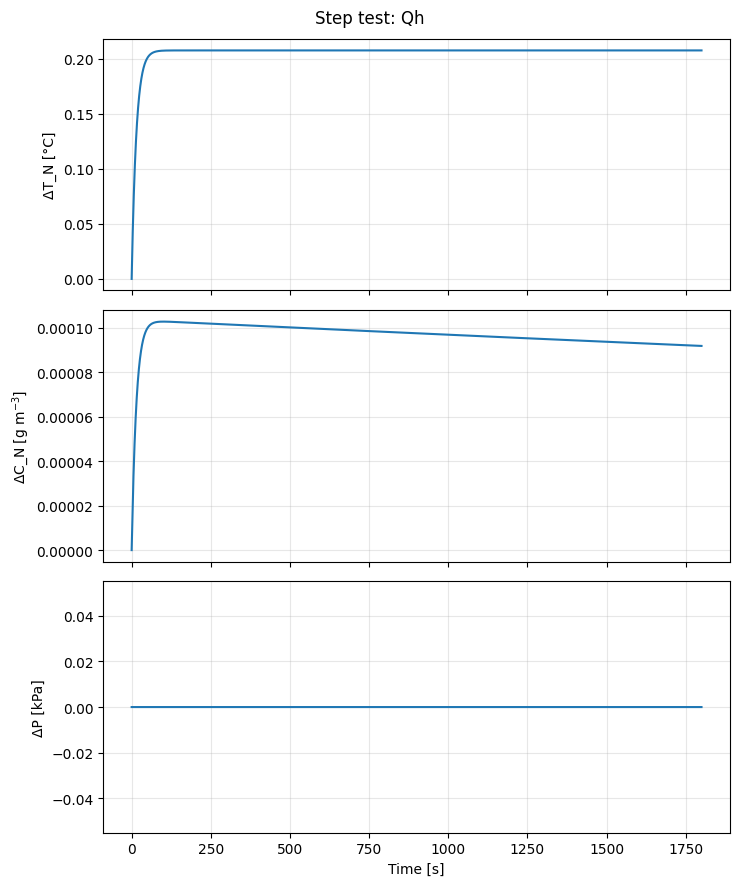

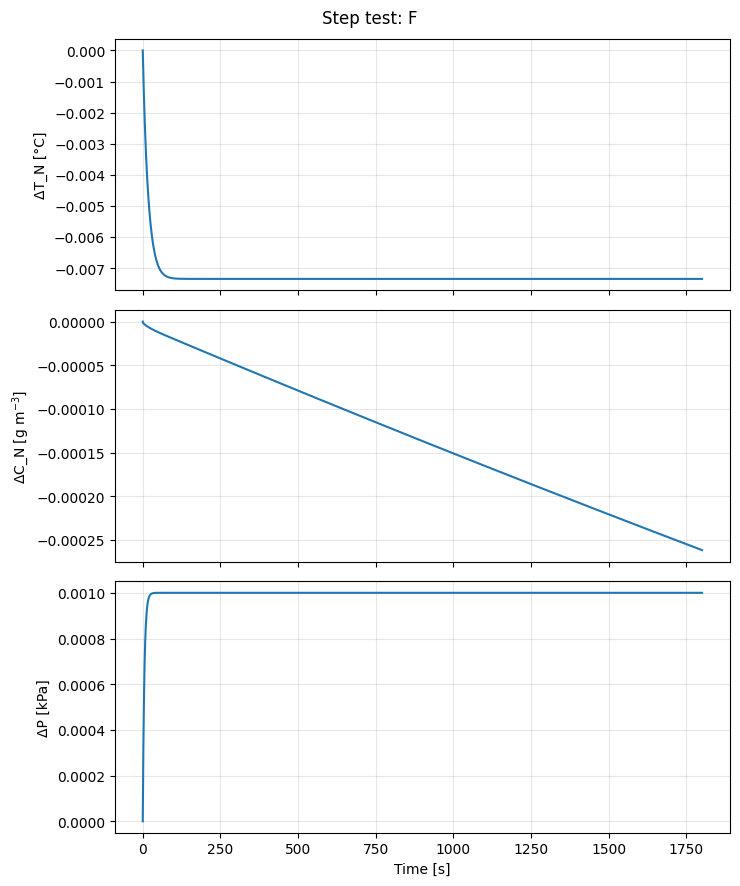

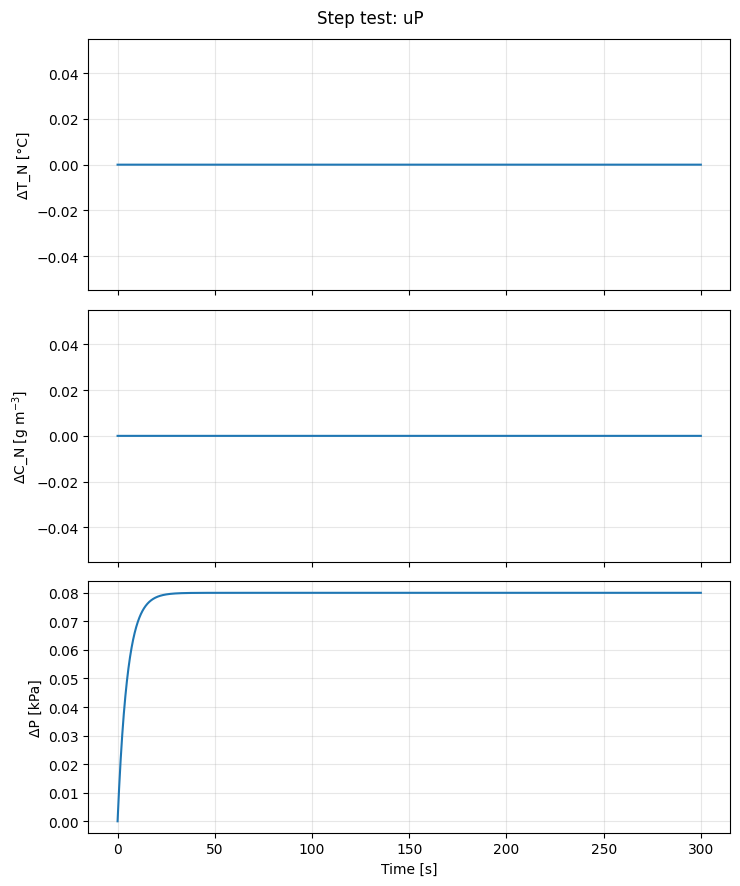

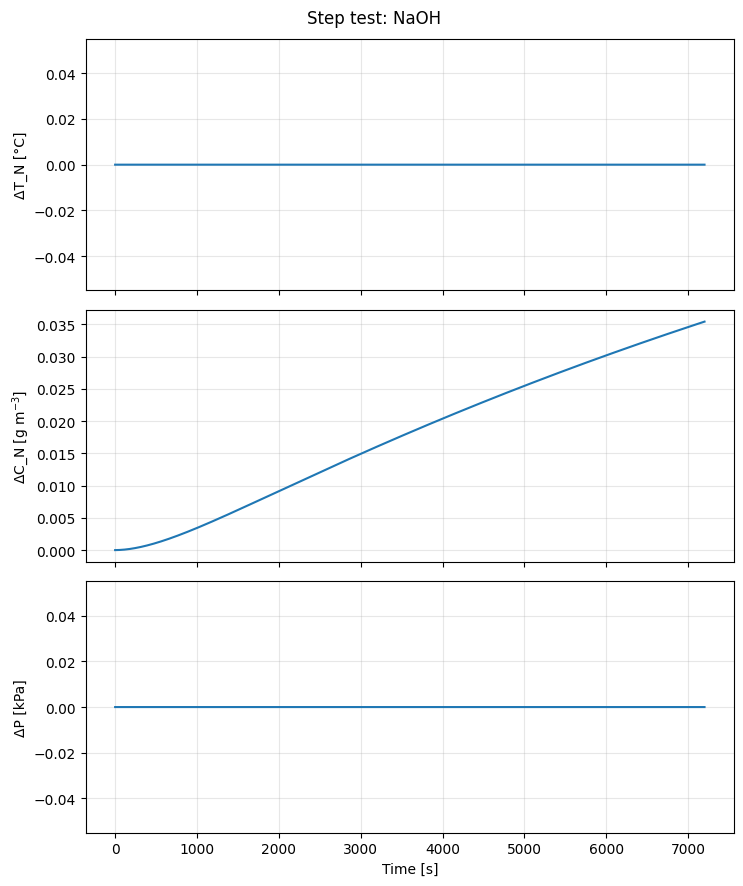

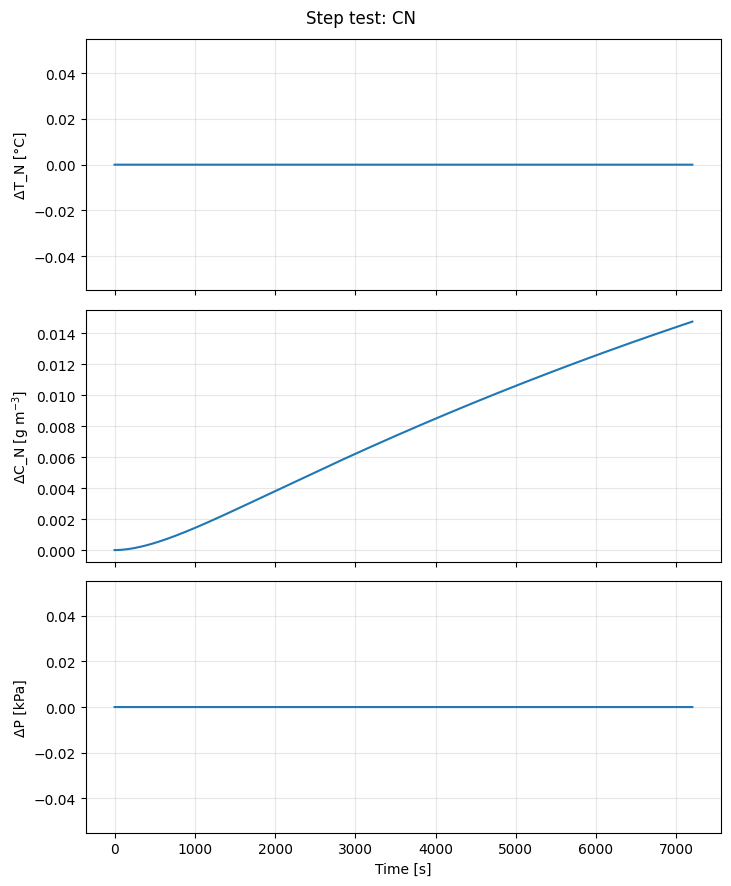

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Parameters
# -----------------------------
N = 3
F_star = 3.0/3600.0                   # m^3/s (3 m^3/h)
rho, Cp = 1000.0, 4200.0
epsilon = 0.45
UA_list = [2.0e4]*N                   # W/K per segment
V_list  = [0.15]*N                    # m^3 per segment
rho_s   = 1200.0
Ms_list = [(1-epsilon)*rho_s*V for V in V_list]

# Macro mass transfer & equilibrium slopes
kLDF  = [1/8.0]*N                     # 1/s (tau ≈ 8 s)
S_C   = [0.25, 0.22, 0.20]
S_T   = [-1e-4]*N

# Heater-duty → wall-temperature fraction
g_list = [0.30, 0.25, 0.20]

# Linearisation profiles (for sign enforcement on F)
T_star = [80.0, 78.5, 77.0]           # °C
C_star = [0.80, 0.60, 0.45]           # g/m^3

# Pressure surrogate
tauP  = 5.0                           # s
dP_dF = 50.0                          # kPa / (m^3/s)
dP_du = 0.80                          # kPa / (% opening)


# Chemistry pool (ensures NaOH/CN steps have a plateau)
tau_c = 600.0                         # s (pool time constant)
G_Na  = 0.06                          # pool gain from NaOH input   
G_CN  = 0.025                         # pool gain from CN input     

# Distribute pool to segments by volume fraction
beta  = np.array(V_list)/sum(V_list)

# Stronger liquid washout and a small universal liquid sink
tau_wash = 120.0                      # s  (stronger washout)
k_sink   = 1.0/80.0                  # 1/s (weak universal sink)

# -----------------------------
# 2) Build LTI model (A,B,C,D)
# -----------------------------
def build_mimo():
    n_core = 3*N + 1    # C (N) + q (N) + T (N) + P (1)
    nstates = n_core + 1  # + w (chemistry pool)
    nin = 5
    A = np.zeros((nstates, nstates), float)
    B = np.zeros((nstates, nin), float)

    def iC(i): return i
    def iq(i): return N + i
    def iT(i): return 2*N + i
    def iP():  return 3*N
    iW = n_core  # chemistry pool state

    for i in range(N):
        V, UA, Ms = V_list[i], UA_list[i], Ms_list[i]
        k, SC, ST, g = kLDF[i], S_C[i], S_T[i], g_list[i]

        # upstream contrast (counter-current)
        Ti   = T_star[i]
        Tim1 = T_star[i-1] if i>0 else T_star[0]-15.0
        Ci   = C_star[i]
        Cim1 = C_star[i-1] if i>0 else C_star[0]-0.40

        alpha = F_star/(epsilon*V)                # convection for C
        gamma = F_star/(epsilon*V)                # convection for T
        delta = UA/(rho*Cp*epsilon*V)             # heat-transfer factor
        s = F_star / Ms if Ms>0 else 0.0          # tiny solid downflow coupling

        # ---- Liquid concentration
        A[iC(i), iC(i)] += -alpha - (1-epsilon)*rho_s/epsilon * k*SC - 1.0/tau_wash
        A[iC(i), iC(i)] += -k_sink   # PATCHED: universal sink
        if i-1 >= 0: A[iC(i), iC(i-1)] += alpha
        A[iC(i), iq(i)] += (1-epsilon)*rho_s/epsilon * (k + s)
        if i+1 < N: A[iC(i), iq(i+1)] += -(1-epsilon)*rho_s/epsilon * s
        A[iC(i), iT(i)] += -(1-epsilon)*rho_s/epsilon * k*ST
        # strictly proper chemistry injection from pool w
        A[iC(i), iW] += beta[i]

        # F→C enforced negative near nominal
        B[iC(i), 1] += -abs((Ci - Cim1)/(epsilon*V))

        # ---- Solid loading
        A[iq(i), iq(i)] += -(k + s)
        if i+1 < N: A[iq(i), iq(i+1)] += s
        A[iq(i), iC(i)] += k*SC
        A[iq(i), iT(i)] += k*ST

        # ---- Temperature
        A[iT(i), iT(i)] += -gamma - delta
        if i-1 >= 0: A[iT(i), iT(i-1)] += gamma
        B[iT(i), 0] += delta * g
        # F→T enforced negative
        B[iT(i), 1] += -abs((Ti - Tim1)/(epsilon*V))

    # ---- Pressure surrogate
    A[iP(), iP()] = -1.0/tauP
    B[iP(), 1] =  dP_dF/tauP
    B[iP(), 2] =  dP_du/tauP

    # ---- Chemistry pool (strictly proper)
    A[iW, iW] = -1.0/tau_c
    B[iW, 3]  =  G_Na/tau_c           # NaOH input to pool
    B[iW, 4]  =  G_CN/tau_c           # CN input to pool

    # ---- Outputs
    C = np.zeros((3, nstates), float)
    D = np.zeros((3, nin), float)
    C[0, 2*N + (N-1)] = 1.0   # T_N
    C[1, (N-1)] = 1.0         # C_N
    C[2, 3*N] = 1.0           # P
    return A, B, C, D

A, B, C, D = build_mimo()

# -----------------------------
# 3) Stable simulation (Backward Euler)
# -----------------------------
def simulate(A, B, C, D, u_vec, Tfinal=1800.0, dt=0.2):
    n = A.shape[0]
    I = np.eye(n, dtype=float)
    M = I - dt*A
    x = np.zeros(n, dtype=float)
    t = np.arange(0.0, Tfinal+dt, dt, dtype=float)
    Y = np.zeros((len(t), C.shape[0]), dtype=float)
    for k in range(len(t)):
        Y[k, :] = C @ x + D @ u_vec
        rhs = x + dt*(B @ u_vec)
        x = np.linalg.solve(M, rhs)
        if not np.all(np.isfinite(x)):
            raise FloatingPointError("State blew up (Inf/NaN). Reduce dt or gains.")
    return t, Y

# -----------------------------
# 4) Step tests + plots
# -----------------------------
tests = {
    "Qh":   np.array([ 1.0,     0.0,    0.0,   0.0,   0.0]),
    "F":    np.array([ 0.0,  2e-5,     0.0,   0.0,   0.0]),    # ≈ 0.072 m^3/h
    "uP":   np.array([ 0.0,     0.0,    0.1,   0.0,   0.0]),
    "NaOH": np.array([ 0.0,     0.0,    0.0,   0.1,   0.0]),
    "CN":   np.array([ 0.0,     0.0,    0.0,   0.0,   0.1]),
}

def plot_panel(name, t, Y):
    labels = ["ΔT_N [°C]", "ΔC_N [g m$^{-3}$]", "ΔP [kPa]"]
    fig, ax = plt.subplots(3, 1, figsize=(7.5, 9), sharex=True)
    for j in range(3):
        ax[j].plot(t, Y[:, j])
        ax[j].set_ylabel(labels[j]); ax[j].grid(True, alpha=0.3)
    ax[-1].set_xlabel("Time [s]")
    fig.suptitle(f"Step test: {name}", y=0.98)
    fig.tight_layout()
    plt.show(); plt.close(fig)

for name, u in tests.items():
    Tfinal = 7200.0 if name in ("NaOH","CN") else (1800.0 if name in ("Qh","F") else 300.0)
    dt = 0.2 if name in ("Qh","F","NaOH","CN") else 0.1
    t, Y = simulate(A, B, C, D, u, Tfinal=Tfinal, dt=dt)
    plot_panel(name, t, Y)